In [3]:
!pip install pandas
!pip install requests
!pip install xarray
!pip install geopandas
!pip install pyaxis
!pip install matplotlib
!pip install owslib

In [4]:
import pandas as pd
import requests
from matplotlib import pyplot
import xarray as xr
import geopandas as gpd
import xarray as xr
import pyaxis
import owslib
import tempfile

## Introduction

This notebook helps you go through the dataset listed under the **DATA** section of the challenge. Below you fill find some examples on how to load dataset depending on its format.

# Datasets

## 1. TXT Example

The first data from the list called [**Homogeneous data series since 1864, temp and precipitation, per month/year**](https://www.meteoswiss.admin.ch/home/climate/swiss-climate-in-detail/homogeneous-data-series-since-1864.html?region=Table) gives you an insight of precipitation or temperature through the years in different areas in Switzerland. 

You can access to a given dataset as such :

In [4]:
url_prec_ge = "https://www.meteoswiss.admin.ch/product/output/climate-data/homogenous-monthly-data-processing/data/homog_mo_GVE.txt"

In [5]:
response = requests.get(url_prec_ge)

In [8]:
with open("./data/GE.txt", "w") as f:
    f.write(response.text)

In [9]:
df = pd.read_csv("./data/GE.txt", encoding="ISO-8859-1", header = 18, delim_whitespace=True)

In [10]:
df

,Year,Month,Temperature,Precipitation
0,1864,1,-4.2,13.6
1,1864,2,-0.7,17.2
2,1864,3,5.3,32.7
3,1864,4,8.3,35.2
4,1864,5,13.5,68.9
...,...,...,...,...
1899,2022,4,10.3,54.0
1900,2022,5,17.6,12.0
1901,2022,6,21.2,63.9
1902,2022,7,23.6,5.0


In [11]:
series = df
print(series.head())

   Year  Month  Temperature  Precipitation
0  1864      1         -4.2           13.6
1  1864      2         -0.7           17.2
2  1864      3          5.3           32.7
3  1864      4          8.3           35.2
4  1864      5         13.5           68.9


In [17]:
series['DATE'] = pd.to_datetime(series[['Year', 'Month']].assign(DAY=1))

In [18]:
series.head()

,Year,Month,Temperature,Precipitation,DATE
0,1864,1,-4.2,13.6,1864-01-01
1,1864,2,-0.7,17.2,1864-02-01
2,1864,3,5.3,32.7,1864-03-01
3,1864,4,8.3,35.2,1864-04-01
4,1864,5,13.5,68.9,1864-05-01


<AxesSubplot:xlabel='Year'>

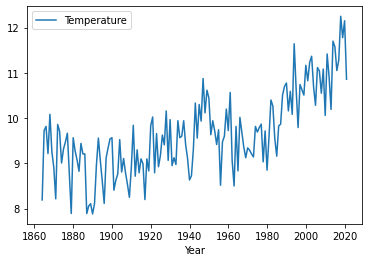

In [47]:
# Average temp through the years in Geneva
series[:-8].groupby('Year', as_index=False).agg({"Temperature": "mean"}).plot(x='Year', y='Temperature')

<AxesSubplot:xlabel='Year'>

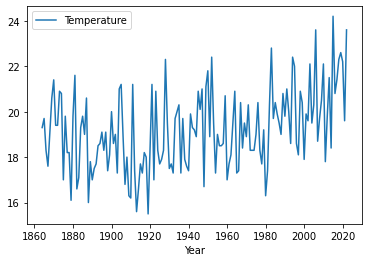

In [44]:
# Temp though the years for July in Geneva
series.loc[series["Month"]==7].plot(x='Year', y='Temperature')

<AxesSubplot:xlabel='Year'>

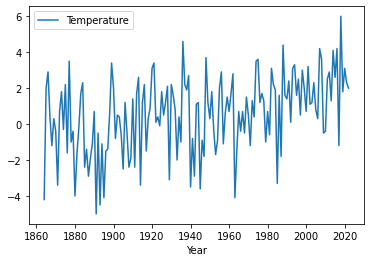

In [45]:
# Temp though the years for January in Geneva
series.loc[series["Month"]==1].plot(x='Year', y='Temperature')

<AxesSubplot:xlabel='Year'>

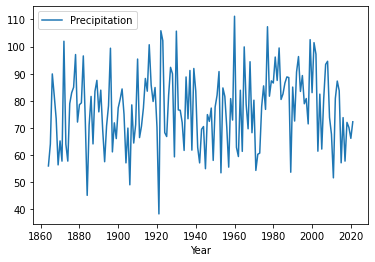

In [46]:
series[:-8].groupby('Year', as_index=False).agg({"Precipitation": "mean"}).plot(x='Year', y='Precipitation')

## 2. CSV Example

In the link called [Klimamessnetz Tageswerte seit Messbeginn](https://opendata.swiss/de/dataset/klimamessnetz-tageswerte), you can download a zip file containing multiple csv. 

Check text file in [this](https://data.geo.admin.ch/ch.meteoschweiz.klima/nbcn-tageswerte/data.zip) zip to get an explenation of the data.

### List of urls

In [135]:
url_list = "https://data.geo.admin.ch/ch.meteoschweiz.klima/nbcn-tageswerte/liste-download-nbcn-d.csv"

In [140]:
df_urls = pd.read_csv(url_list, encoding="ISO-8859-1", sep = ";")

In [ ]:
for index, row in df_urls[:30].iterrows():
    print(row["URL Current year"]) # Also URL Previous years (verified data)

# 3 .NC Example

Data taken from this [url](https://opendata.swiss/de/dataset/klimamessnetz-tageswerte). Access to the text file within the zip folder to get the different urls to download a specific dataset.

In this example, we used this [link](https://data.geo.admin.ch/ch.meteoschweiz.klimanormwerte-niederschlag_1961_1990/netcdf/2056/RnormY6190_ch01r.swiss.lv95_000001010000_000001010000.nc)

In [2]:
ds = xr.open_dataset('./data/RnormY6190_ch01r.swiss.lv95_000001010000_000001010000.nc', decode_times=False)
df = ds.to_dataframe()

In [3]:
df.to_csv("./data/nc.csv")

In [4]:
df.head()

swiss_lv95_coordinates  climatology_bounds  \
ncb time E         N                                                       
1.0 0.0  2474500.0 1064500.0                     1.0                 0.0   
                   1065500.0                     1.0                 0.0   
                   1066500.0                     1.0                 0.0   
                   1067500.0                     1.0                 0.0   
                   1068500.0                     1.0                 0.0   

                              RnormY6190       lon        lat  
ncb time E         N                                           
1.0 0.0  2474500.0 1064500.0         NaN  5.826852  45.720608  
                   1065500.0         NaN  5.826589  45.729603  
                   1066500.0         NaN  5.826325  45.738594  
                   1067500.0         NaN  5.826061  45.747589  
                   1068500.0         NaN  5.825797  45.756580

In [7]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat))

<AxesSubplot:>

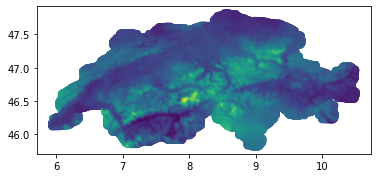

In [10]:
gdf.plot(column ="RnormY6190")

In [8]:
gdf.to_file("./data/geojson.json", driver="GeoJSON") # allow to get an geojson file, I use it on kepler to "play" around more easily

# 4. PX Example

In [1]:
from pyaxis import pyaxis

#set file path (or URL)
fp = r"https://dam-api.bfs.admin.ch/hub/api/dam/assets/12947667/master" 
#parse contents of *.px file
px = pyaxis.parse(uri = fp , encoding = 'ISO-8859-2')

#store data as pandas dataframe
data_df = px['DATA']
#store metadata as a dictionary (not necessary in this case, but might be helpful)
meta_dict = px['METADATA']

In [2]:
data_df

,Szenario-Variante,Staatsangehörigkeit (Kategorie),Geschlecht,Altersklasse,Jahr,Beobachtungseinheit,DATA
0,Referenzszenario A-00-2020,Staatsangehörigkeit - Total,Geschlecht - Total,Altersklasse - Total,2019,Bevölkerungsstand am 1. Januar,8544527
1,Referenzszenario A-00-2020,Staatsangehörigkeit - Total,Geschlecht - Total,Altersklasse - Total,2019,Lebendgeburten,88682
2,Referenzszenario A-00-2020,Staatsangehörigkeit - Total,Geschlecht - Total,Altersklasse - Total,2019,Todesfälle,67363
3,Referenzszenario A-00-2020,Staatsangehörigkeit - Total,Geschlecht - Total,Altersklasse - Total,2019,Einwanderungen,175000
4,Referenzszenario A-00-2020,Staatsangehörigkeit - Total,Geschlecht - Total,Altersklasse - Total,2019,Auswanderungen,125000
...,...,...,...,...,...,...,...
1497595,Variante A-07-2020 'stabile Auswanderungsziffern',Ausland Nicht-EWR,Frau,115-120 Jahre,2070,Einwanderungen,0
1497596,Variante A-07-2020 'stabile Auswanderungsziffern',Ausland Nicht-EWR,Frau,115-120 Jahre,2070,Auswanderungen,0
1497597,Variante A-07-2020 'stabile Auswanderungsziffern',Ausland Nicht-EWR,Frau,115-120 Jahre,2070,Erwerb des Schweizer Bürgerrechts,0
1497598,Variante A-07-2020 'stabile Auswanderungsziffern',Ausland Nicht-EWR,Frau,115-120 Jahre,2070,Bevölkerungsstand am 31. Dezember,0


# 5 WFS Example

In [5]:
from owslib.wfs import WebFeatureService
from requests import Request
url = "https://map.geo.sz.ch/mapserv_proxy" # WFS URL as Example
wfs = WebFeatureService(url=url, version = "1.1.0") # Depending on the provider, you can use version 2.0.0
layer_list = list(wfs.contents) # Gives you a list of layers available for this URL
layer = "ms:ch.sz.a012.naturgefahrenkarte.synoptisch.aggregiert.gstufe_erheblich_mittel" # Layer to adapt

In [6]:
response = wfs.getfeature(typename=layer, maxfeatures=10) #Max Features set to 100 for example, you can remove it
data = response.read()

In [7]:
with tempfile.NamedTemporaryFile() as temp:
    temp.write(data)
    gdf = gpd.read_file(temp.name)

In [8]:
gdf.head()

,gml_id,label_hochwasser,label_rutschung,label_sturz,label_lawine,label_gleitschnee,label_doline,pzg_cd,geometry
0,ch.sz.a012.naturgefahrenkarte.synoptisch.aggre...,keine Gefährdung,Gefahrenhinweis,keine Gefährdung,keine Gefährdung,keine Gefährdung,keine Gefährdung,50,"POLYGON ((2705390.210 1212769.050, 2705390.250..."
1,ch.sz.a012.naturgefahrenkarte.synoptisch.aggre...,Gefahrenhinweis,Gefahrenhinweis,keine Gefährdung,keine Gefährdung,keine Gefährdung,keine Gefährdung,550,"POLYGON ((2700145.828 1210144.033, 2700146.953..."
2,ch.sz.a012.naturgefahrenkarte.synoptisch.aggre...,keine Gefährdung,Gefahrenhinweis,Gefahrenhinweis,keine Gefährdung,keine Gefährdung,keine Gefährdung,5050,"POLYGON ((2705177.353 1212297.518, 2705175.310..."
3,ch.sz.a012.naturgefahrenkarte.synoptisch.aggre...,Gefahrenhinweis,Gefahrenhinweis,keine Gefährdung,keine Gefährdung,Gefahrenhinweis,keine Gefährdung,50550,"POLYGON ((2701633.270 1208592.200, 2701634.770..."
4,ch.sz.a012.naturgefahrenkarte.synoptisch.aggre...,keine Gefährdung,keine Gefährdung,Gefahrenhinweis,Gefahrenhinweis,Gefahrenhinweis,keine Gefährdung,555000,"POLYGON ((2705049.635 1207076.152, 2705045.958..."


# 6 API ARCGIS Example

In [380]:
url = "https://api.geo.admin.ch/rest/services/api/MapServer/identify"

envelope = "548945.5,147956,549402,148103.5" # Swiss coordinates 21781
layers = "all:ch.are.belastung-personenverkehr-bahn_zukunft" # Layer selected
todo = {"layers":layers,
        "geometryType":"esriGeometryEnvelope", 
        "geometry":envelope,
        "geometryFormat":"geojson", 
        "tolerance":"1", 
        "imageDisplay":"500,600,96", 
        "mapExtent":envelope}
response = requests.get(url, params = todo)

In [381]:
json_file = json.loads(response.content)
df = pd.read_json(json.dumps(json_file["results"]))

In [382]:
# Transform column geom into a geoshape
from shapely.geometry import shape
def transform_to_shape(origin):
    temp = [origin]
    geom = [shape(i) for i in temp]
    return geom[0]
df['geom'] = df.apply(lambda row : transform_to_shape(row['geometry']), axis = 1)
gdf = gpd.GeoDataFrame(df, geometry=df["geom"])
gdf = gdf.set_crs("21781").to_crs("4326")
gdf["geometry"].plot()

In [385]:
df1 = pd.DataFrame(df['properties'].values.tolist())
final_df = df[["id", "layerName", "geometry"]].join(df1)

In [386]:
final_df

,id,layerName,geometry,nr,dwv_oev,dtv_oev,msp_oev,asp_oev,label
0,7646,Personenverkehr Schiene 2050,"LINESTRING (548128.800 148744.100, 548130.800 ...",980000896,1794,1594,155,177,980000896
1,7647,Personenverkehr Schiene 2050,"LINESTRING (549310.000 147962.100, 549316.200 ...",980000896,2157,1951,170,220,980000896
